In [2]:
import sys
sys.path.append("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/")
from src.HNLimits import hnl_tools

In [42]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("figures.mplstyle")

from hepunits import g
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
from scipy.interpolate import CloughTocher2DInterpolator

from src.constants import *


In [54]:
def plot_existing_limits(case):
    for case,limit in case_muon.limits.iterrows():
        try:
            if limit.m4_top is not None and limit.plot_label not in ['Cosmology', "NuTeV"]:
                # Create points for convex hull
                # Combine bottom and top curves
                points = np.column_stack([limit.m4,limit.ualpha4])

                # Remove any duplicate or invalid points
                points = points[~np.isnan(points).any(axis=1)]

                if len(points) > 2:
                    # Compute convex hull
                    hull = ConvexHull(points)

                    # Create polygon from hull vertices
                    hull_points = points[hull.vertices]
                    polygon = patches.Polygon(hull_points, closed=True, alpha=1,
                                            facecolor='lightgray',edgecolor='gray')
                    plt.gca().add_patch(polygon)
            else:
                x = m4_range
                y = limit.interp_func(m4_range)
                ytop = limit.interp_func_top(m4_range)
                nan_mask = np.logical_not(np.isnan(y) | np.isnan(ytop))
                x = x[nan_mask]
                y = y[nan_mask]
                ytop = ytop[nan_mask]
                if limit.m4_top is None or np.max(np.abs(y-ytop))<1e-3:
                    ytop = 1e-2*np.ones_like(ytop)
                if limit.plot_label == "Cosmology":
                    plt.fill_between(x,y,ytop, alpha=0.2, facecolor='lightgray',edgecolor='gray')
                else:
                    plt.fill_between(x,y,ytop, alpha=1, facecolor='lightgray',edgecolor='gray')
        except Exception as e:
            print(f"Could not plot limit {limit.plot_label}: {e}")

In [34]:
m4_range = np.logspace(-2,3,1000)

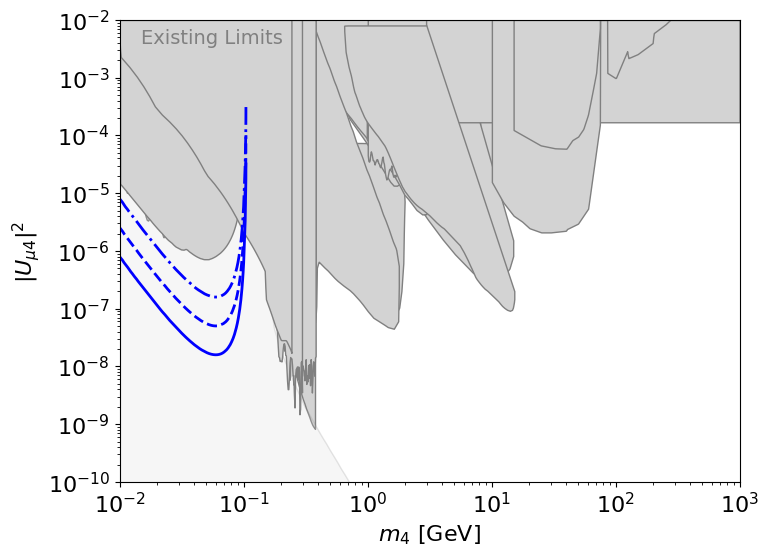

In [55]:
# muon limits

# first, plot existing limits
plt.text(0.015,4e-3,"Existing Limits",color="gray",fontsize=14)
case_muon = hnl_tools.Limits(flavor='mu', invisible=False, nature='majorana')
plot_existing_limits(case_muon)

# now loop through existing data
for level in range(3):
    contour_data = np.loadtxt("data/HNL_events_muon_mixing_contour_%d_events.txt"%level)
    # split into segments based on NaN rows
    segments = np.split(contour_data, np.where(np.isnan(contour_data).all(axis=1))[0])
    for segment in segments:
        if segment.size == 0:
            continue
        plt.plot(segment[:,0], segment[:,1], label=f"{[1,10,100][level]} Events", linestyle=['-','--','-.'][level], color='blue')


plt.loglog()
plt.xlim(m4_range[0], m4_range[-1])
plt.ylim(1e-10,1e-2)
plt.xlabel(r"$m_4$ [GeV]", fontsize=16)
plt.ylabel(r"$|U_{\mu4}|^2$", fontsize=16)
plt.show()

ValueError: Limit file /n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/src/HNLimits/include/data/NA62_pion_2025/Ue4sqr.dat does not exist.

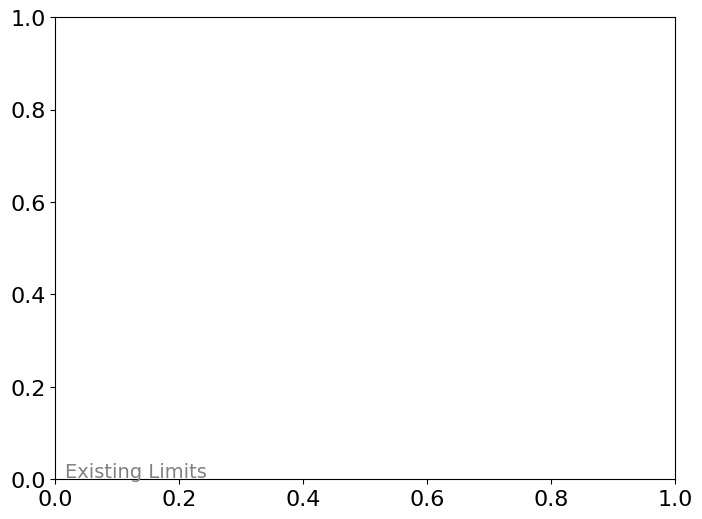

In [56]:
# electron limits

# first, plot existing limits
plt.text(0.015,4e-3,"Existing Limits",color="gray",fontsize=14)
case_electron = hnl_tools.Limits(flavor='e', invisible=False, nature='majorana')
plot_existing_limits(case_electron)

# now loop through existing data
for level in range(3):
    contour_data = np.loadtxt("data/HNL_events_electron_mixing_contour_%d_events.txt"%level)
    # split into segments based on NaN rows
    segments = np.split(contour_data, np.where(np.isnan(contour_data).all(axis=1))[0])
    for segment in segments:
        if segment.size == 0:
            continue
        plt.plot(segment[:,0], segment[:,1], label=f"{[1,10,100][level]} Events", linestyle=['-','--','-.'][level], color='blue')


plt.loglog()
plt.xlim(m4_range[0], m4_range[-1])
plt.ylim(1e-10,1e-2)
plt.xlabel(r"$m_4$ [GeV]", fontsize=16)
plt.ylabel(r"$|U_{e4}|^2$", fontsize=16)
plt.show()